In [1]:
import os
from collections import OrderedDict

import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

from nengo_learn_assoc_mem.paths import data_path

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_rt(integ_res, thresh: float) -> np.array:
    react_tms = []

    for i_res in integ_res:
        whr = np.where(i_res > thresh)
        if len(whr[0]) == 0:
            react_tms.append(-1)
        else:
            react_tms.append(whr[0][0])
    
    return np.array(react_tms)

In [162]:
read_path = os.path.join(data_path, "static_react", "low2_cept_enc_confidence.h5")

with h5py.File(read_path, "r") as fi:
    print(list(fi.keys()))

['comp_res_0', 'comp_res_1', 'comp_res_2', 'comp_res_3', 'comp_res_4', 'comp_res_5', 'comp_res_6', 'comp_res_7', 'comp_res_8', 'comp_res_9', 'integ_res_neg_0', 'integ_res_neg_1', 'integ_res_neg_2', 'integ_res_neg_3', 'integ_res_neg_4', 'integ_res_neg_5', 'integ_res_neg_6', 'integ_res_neg_7', 'integ_res_neg_8', 'integ_res_neg_9', 'integ_res_pos_0', 'integ_res_pos_1', 'integ_res_pos_2', 'integ_res_pos_3', 'integ_res_pos_4', 'integ_res_pos_5', 'integ_res_pos_6', 'integ_res_pos_7', 'integ_res_pos_8', 'integ_res_pos_9']


In [163]:
stim_types = ("fan1", "fan2", "foil1", "foil2")

total_err_rates = OrderedDict([(s_t, []) for s_t in stim_types])
total_rt = OrderedDict([(s_t, []) for s_t in stim_types])
n_vecs = 16
train_len = n_vecs * 2

for seed_val in range(10):
    with h5py.File(read_path, "r") as fi:
        comp_res = np.array(fi[f"comp_res_{seed_val}"]).squeeze()
        neg_integ_res = np.array(fi[f"integ_res_neg_{seed_val}"]).squeeze()
        pos_integ_res = np.array(fi[f"integ_res_pos_{seed_val}"]).squeeze()

    pos_thresh = np.mean(pos_integ_res[:train_len], axis=0)[-1] * 0.65
    neg_thresh = np.mean(neg_integ_res[:train_len], axis=0)[-1] * 1.6

    pos_rt = get_rt(pos_integ_res, pos_thresh)
    max_pos_rt = np.max(pos_rt)
    neg_rt = get_rt(neg_integ_res, neg_thresh)
    max_neg_rt = np.max(neg_rt)
    
    nans_idx = (pos_rt == -1) & (neg_rt == -1)
    if np.any(nans_idx):
        nans_loc = np.where(nans_idx == True)[0]
        print(f"No answer detected {len(nans_loc)} times for seed {seed_val}")

        pos_nans_loc = nans_loc[nans_loc < 32]
        if len(pos_nans_loc) > 0:
            neg_rt[pos_nans_loc] = max_neg_rt

        neg_nans_loc = nans_loc[nans_loc > 32]
        if len(neg_nans_loc) > 0:
            pos_rt[pos_nans_loc] = max_pos_rt

    all_max = np.max([max_pos_rt, max_neg_rt]) + 10
    pos_rt[pos_rt < 0] = all_max
    neg_rt[neg_rt < 0] = all_max
    all_rt = np.array([pos_rt, neg_rt]).max(axis=0)
    
    cor_targ_resp = np.zeros(train_len, dtype=np.bool)
    cor_targ_resp[pos_rt[:train_len] < neg_rt[:train_len]] = True

    cor_foil_resp = np.zeros(train_len, dtype=np.bool)
    cor_foil_resp[pos_rt[train_len:] > neg_rt[train_len:]] = True

    total_err_rates["fan1"].append(1 - (np.sum(cor_targ_resp[:16]) / 16))
    total_err_rates["fan2"].append(1 - (np.sum(cor_targ_resp[16:]) / 16))
    total_err_rates["foil1"].append(1 - (np.sum(cor_foil_resp[:16]) / 16))
    total_err_rates["foil2"].append(1 - (np.sum(cor_foil_resp[16:]) / 16))
    
    
    for s_i, stim_li in enumerate(total_rt.values()):
        rt_slc = slice(s_i*n_vecs, (s_i+1)*n_vecs)
        stim_li.append(np.mean(all_rt[rt_slc]))

In [164]:
df_rt = pd.DataFrame(total_rt)
df_rt.head()

,fan1,fan2,foil1,foil2
0,119.750,118.2500,116.375,117.3750
1,122.875,120.5625,120.375,120.1250
2,114.000,114.0000,114.000,114.0000
3,124.000,124.0000,122.250,120.9375
4,113.000,113.0000,113.000,113.0000


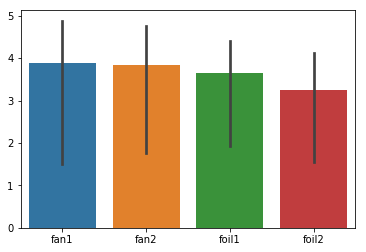

In [165]:
sns.barplot(data=df_rt, estimator=np.std)

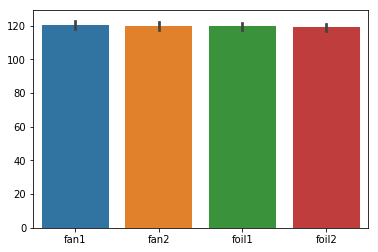

In [166]:
sns.barplot(data=df_rt)

In [158]:
df_rt.to_hdf(os.path.join(data_path, "react_err_dfs", "rt.h5"), key="react", mode="w")

In [159]:
df_err = pd.DataFrame(total_err_rates)
df_err.head()

,fan1,fan2,foil1,foil2
0,0.0000,0.000,0.0000,0.1250
1,0.0625,0.000,0.0625,0.1250
2,0.0625,0.000,0.0000,0.3125
3,0.0625,0.000,0.0000,0.5625
4,0.0625,0.125,0.0000,0.6250


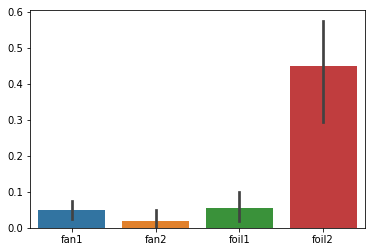

In [160]:
sns.barplot(data=df_err)

In [161]:
df_err.to_hdf(os.path.join(data_path, "react_err_dfs", "low_err.h5"), key="error", mode="w")

# Scrap and draft

In [135]:
seed_val = 2

with h5py.File(read_path, "r") as fi:
    comp_res = np.array(fi[f"comp_res_{seed_val}"]).squeeze()
    neg_integ_res = np.array(fi[f"integ_res_neg_{seed_val}"]).squeeze()
    pos_integ_res = np.array(fi[f"integ_res_pos_{seed_val}"]).squeeze()

In [136]:
pos_thresh = np.mean(pos_integ_res[:train_len], axis=0)[-1] * 0.65
neg_thresh = np.mean(neg_integ_res[:train_len], axis=0)[-1] * 1.6

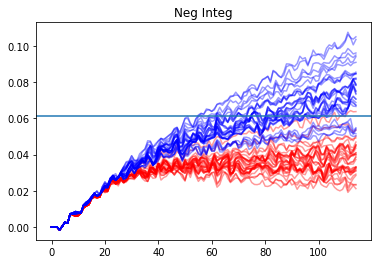

In [137]:
plt.title("Neg Integ")
plt.plot(np.array(neg_integ_res[:train_len]).squeeze().T, color='r', alpha=0.4)
plt.plot(np.array(neg_integ_res[train_len:]).squeeze().T, color='b', alpha=0.4);
plt.axhline(neg_thresh)

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


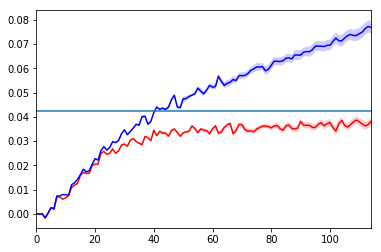

In [138]:
sns.tsplot(neg_integ_res[:train_len], color='r')
sns.tsplot(neg_integ_res[train_len:], color='b')
plt.axhline(pos_thresh)

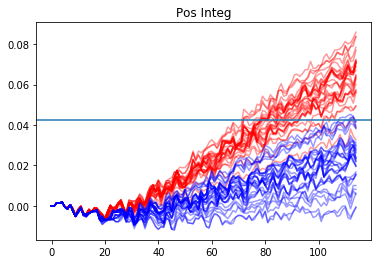

In [139]:
plt.title("Pos Integ")
plt.plot(pos_integ_res[:train_len].T, color='r', alpha=0.4)
plt.plot(pos_integ_res[train_len:].T, color='b', alpha=0.4)
plt.axhline(pos_thresh)

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


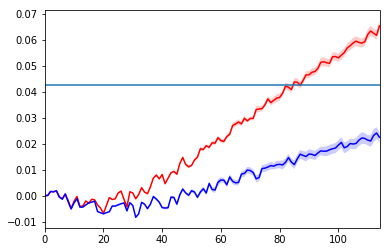

In [141]:
sns.tsplot(pos_integ_res[:train_len], color='r')
sns.tsplot(pos_integ_res[train_len:], color='b')
plt.axhline(pos_thresh)

In [142]:
pos_rt = get_rt(pos_integ_res, pos_thresh)
max_pos_rt = np.max(pos_rt)
neg_rt = get_rt(neg_integ_res, neg_thresh)
max_neg_rt = np.max(neg_rt)

If RT don't happen for either outcome, it's going to be a bit of a problem.

In [143]:
nans_idx = (pos_rt == -1) & (neg_rt == -1)
if np.any(nans_idx):
    nans_loc = np.where(nans_idx == True)[0]
    print(nans_loc)

    pos_nans_loc = nans_loc[nans_loc < 32]
    if len(pos_nans_loc) > 0:
        neg_rt[pos_nans_loc] = max_neg_rt

    neg_nans_loc = nans_loc[nans_loc > 32]
    if len(neg_nans_loc) > 0:
        pos_rt[pos_nans_loc] = max_pos_rt

[50]


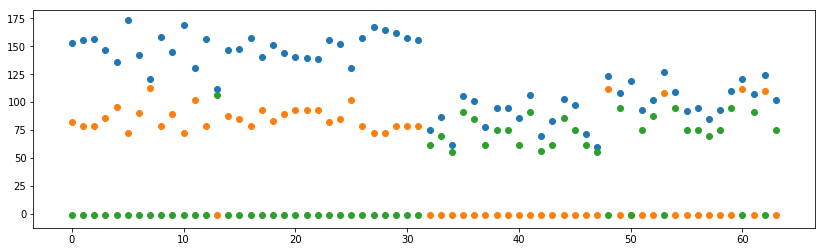

In [144]:
plt.figure(figsize=(14, 4))
plt.scatter(np.arange(64), np.sum(comp_res.squeeze(), axis=1), label="conf")
plt.scatter(np.arange(64), pos_rt, label="pos")
plt.scatter(np.arange(64), neg_rt, label="neg")

In [145]:
all_max = np.max([np.max(pos_rt), np.max(neg_rt)]) + 10

pos_rt[pos_rt < 0] = all_max
neg_rt[neg_rt < 0] = all_max

In [146]:
np.array([pos_rt, neg_rt]).max(axis=0).shape

(64,)

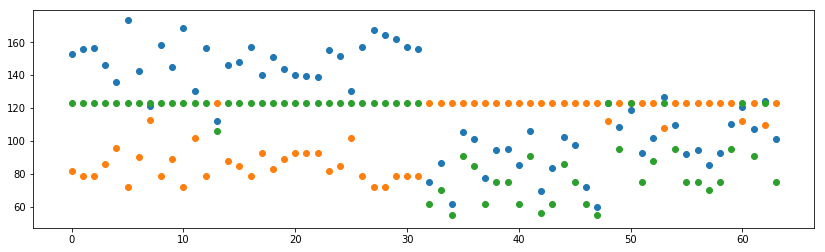

In [147]:
plt.figure(figsize=(14, 4))
plt.scatter(np.arange(64), np.sum(comp_res.squeeze(), axis=1), label="conf")
plt.scatter(np.arange(64), pos_rt, label="pos")
plt.scatter(np.arange(64), neg_rt, label="neg")

In [148]:
cor_targ_resp = np.zeros(train_len, dtype=np.bool)
cor_targ_resp[pos_rt[:train_len] < neg_rt[:train_len]] = True

cor_foil_resp = np.zeros(train_len, dtype=np.bool)
cor_foil_resp[pos_rt[train_len:] > neg_rt[train_len:]] = True

In [149]:
cor_targ_resp

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [150]:
err_rate = 1 - (np.sum(cor_targ_resp[:16]) / 16)
err_rate

0.0625

In [151]:
err_rate = 1 - (np.sum(cor_targ_resp[16:]) / 16)
err_rate

0.0

In [152]:
err_rate = 1 - (np.sum(cor_foil_resp[:16]) / 16)
err_rate

0.0

In [153]:
err_rate = 1 - (np.sum(cor_foil_resp[16:]) / 16)
err_rate

0.3125